# N.B.
This notebook is very similar to the others, changing very few things but leading to different results.

IMPLEMENT THE STEP 2 OF THE ALGORITHM

# Import and constants

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 7.3 MB/s 
     |████████████████████████████████| 101 kB 12.1 MB/s 
     |████████████████████████████████| 6.6 MB 42.6 MB/s 
     |████████████████████████████████| 596 kB 68.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import numpy as np
import random
import json
import os
import matplotlib.pyplot as plt
from collections import defaultdict

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# Transformers
from transformers import AutoTokenizer
from transformers import AutoModel

# For iteration bars
from tqdm.auto import tqdm

In [ ]:
# Set the seed for the randoms
def set_random_seed():
    SEED = 104
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True
set_random_seed()

# Path
ROOT_PATH = "./drive/MyDrive/NLP/HW2/"
ENGLISH_SETS_PATH = ROOT_PATH + "data_hw2/EN/"
SPANISH_SETS_PATH = ROOT_PATH + "data_hw2/ES/"
FRENCH_SETS_PATH = ROOT_PATH + "data_hw2/FR/"
TRAINSET_PATH = "train.json"
DEVSET_PATH = "dev.json"
CHECKPOINTS_PATH = ROOT_PATH + "checkpoints_2/"

# Patience
LEN_STACK_PATIENCE = 4
PATIENCE = 5
# Optim
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 0.0
TRANSFORMER_LEARNING_RATE = 1e-4
TRANSFORMER_WEIGHT_DECAY = 0.0
# Training
BATCH_SIZE = 32
EPOCHS = 100
# Architecture
HIDDEN_DIM_LSTM = 200
EMBEDDING_DIM = 200
BIDIRECTIONAL = True
NUM_LAYER_LSTM = 2
DROPOUT = 0.2
DROPOUT_LSTM = 0.5

# Other
TRANFORMER_CHECKPOINT = "bert-base-uncased"
TOKENIZER = AutoTokenizer.from_pretrained(TRANFORMER_CHECKPOINT)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", DEVICE)

def encode_labels():
    with open(ROOT_PATH + "verbatlas/VA_frame_info.tsv", mode='r', encoding='utf-8') as json_file:
        json_list_verbatlas_info = list(json_file)
    id2label = {0: "_"}
    label2id = {"_": 0}
    labels = ["_"]
    for id, info in enumerate(json_list_verbatlas_info[1:]):
        info_splitted = info.replace("\n", "").split("\t")
        name = info_splitted[1].upper()
        labels.append(name)
        id2label[id+1] = name
        label2id[name] = id+1
    return labels, id2label, label2id
LABELS, ID_TO_LABEL, LABEL_TO_ID = encode_labels()

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

device: cuda


# Classes

## MyDataset
This class allows me to read the dataset and other useful information to preprocess the input that will be delivered to the model.

In [ ]:
class MyDataset(Dataset):
    def __init__(self, mode, language = "en"):
        """
        Args:
            mode: train, if I want to load the training set, 
                  dev if I want load the development set.
            language: "en", "es" or "fr" to load the specific datasets.
        """
        self.mode = mode
        self.language = language
        self.transformer_name = TRANFORMER_CHECKPOINT
        self.sentences, self.predicates = self.read_data_sets()
        self.encoded_data = self.encode()
    
    def read_data_sets(self):
        """
        Method used to read a specific dataset.
        Return:
            A raw dataset.
        """
        if self.language == "en":
            language_path = ENGLISH_SETS_PATH
        elif self.language == "es":
            language_path = SPANISH_SETS_PATH
        elif self.language == "fr":
            language_path = FRENCH_SETS_PATH
        path = language_path + TRAINSET_PATH if self.mode == "train" else language_path + DEVSET_PATH
        return self.read(path)
    
    def read(self, path):
        """
        Method used to read a dataset.
        Args:
            path: path of the dataset
        Return:
            sentences: list of words for each sentence;
            predicates: list of predicates for each sentence. The predicates
                        are parallel to the words.
        """
        with open(path) as f:
            dataset = json.load(f)
        sentences, predicates = [], []
        for sentence_id, sentence in dataset.items():
            sentences.append(sentence["words"])
            predicates.append(sentence["predicates"])
        return sentences, predicates

    def encode(self):
        """
        Method used to convert the input 
        to an encoded input that the model can read.
        Return:
            encoded: list of the input of the model:
                     {
                         transformer_inputs: tokenized sentence,
                         predicate_idx: list of index: 
                                            0 is a padding; 
                                            1 is a word in the sentence; 
                                            2 is a predicate.
                         labels: for each sentence the label are:
                                 -100: If at position i there is a padding;
                                 0: If at position i there isn't a predicate;
                                 n: where n is the id of a specific prdicate if
                                    at position i there is the predicate n
                     }
        P.S. For this method I have taken inspiration from the Notebook 9 shown in the lecture
        """
        tokenized = TOKENIZER(
            self.sentences, 
            return_tensors = "pt", 
            truncation = True, 
            padding = True,
            is_split_into_words = True
        )
        tokenized.to(DEVICE)
        encoded = []
        for i in tqdm(range(len(tokenized["input_ids"])), desc = "Encode", leave = False):
            # Duplicate sentence for each predicate
            for predicate in self.predicates[i]:
                if predicate[-1] == "-":
                    predicate = predicate[:-1]
                if (predicate == "_"):
                    continue
                entry = {}
                for key, value in tokenized.items():
                    entry[key] = value[i]
                word_ids = tokenized.word_ids(batch_index=i)
                previous_word_idx = None
                labels = []
                predicate_idx = []
                for word_idx in word_ids:
                    # Special tokens have a word id that is None.
                    # We set the label to -100 so they are automatically 
                    # ignored in the loss function. 
                    # The same applies to predicate setted to pad
                    if word_idx is None:
                        labels.append(-100)
                        predicate_idx.append(0)
                    # For the first token of each word.
                    elif word_idx != previous_word_idx:
                        # Typo error in the dataset fix. 
                        #   A lot of predicate end with "-"
                        if self.predicates[i][word_idx][-1] == "-":
                            self.predicates[i][word_idx] = self.predicates[i][word_idx][:-1]
                        # Set a proper label and predicate index
                        if self.predicates[i][word_idx] == predicate:
                            labels.append(LABEL_TO_ID[self.predicates[i][word_idx]])
                            predicate_idx.append(2)
                        else:
                            labels.append(LABEL_TO_ID["_"])
                            predicate_idx.append(1)
                    # For the other tokens in a word id that is None.
                    # We set the label to -100 so they are automatically 
                    # ignored in the loss function. 
                    # The same applies to predicate, setted to pad
                    else:
                        predicate_idx.append(0)
                        labels.append(-100)
                    previous_word_idx = word_idx
                predicate_idx = torch.LongTensor(predicate_idx)
                predicate_idx = predicate_idx.unsqueeze(dim = -1).to(DEVICE)
                encoded.append({"transformer_inputs": entry,
                                "predicate_idx": predicate_idx,
                                "labels": torch.LongTensor(labels).to(DEVICE)})
        return encoded

    def __len__(self):
        '''
        Return:
            - number of element in the dataset
        '''
        return len(self.encoded_data)

    def __getitem__(self, idx):
        '''
        Return:
            - i-th element of the dataset to iterate on it
        '''
        return self.encoded_data[idx]

    def __str__(self):
        out = "set type: " + self.mode + "Set"
        out += "\nlanguage: " + self.language
        out += "\ntokenizer used: " + TRANFORMER_CHECKPOINT
        out += "\nset length: " + str(len(self))
        return out

def data_loading(dataset, shuffle):
    """
    Function used to create a dataloader and print some usefull information.
    Args:
        dataset: dataset on which you want to build the dataloader
        shuffle: whether or not I should shuffle the dataloader obtained 
    Return:
        data_loader: the DataLoader object
    """
    data_loader = DataLoader(dataset, batch_size = BATCH_SIZE, shuffle = shuffle)
    print(dataset)
    print("batch size: " + str(BATCH_SIZE))
    print("number of batches: " + str(len(data_loader)))
    return data_loader

##SRL_Model
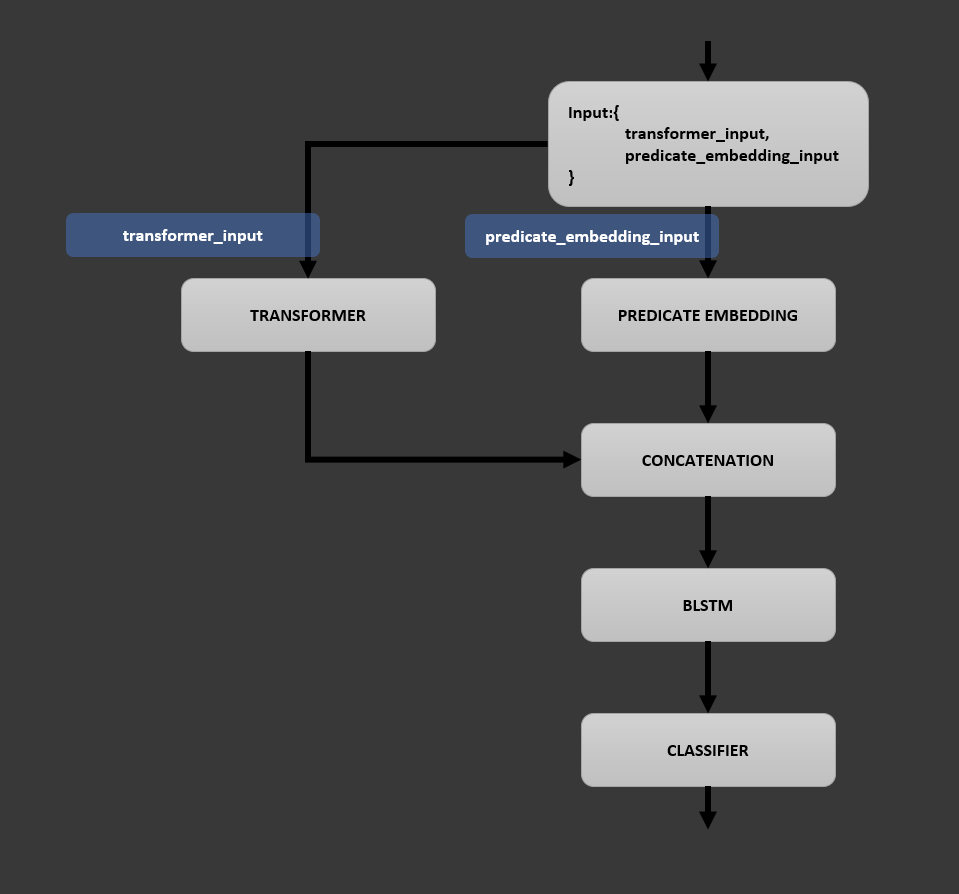

In [ ]:
class SRL_Model_2(nn.Module):
    def __init__(self, hparams):
        super(SRL_Model_2, self).__init__()
        # Number of classes
        self.num_labels = hparams["num_labels"]

        # Embeddings
        self.predicate_embedding = torch.nn.Embedding(3, hparams["embedding_dim"], padding_idx = 0)

        # Transformer
        self.transformer_model = AutoModel.from_pretrained(hparams["transformer_name"], output_hidden_states=True)
        transformer_output_dim = self.transformer_model.config.hidden_size + hparams["embedding_dim"]
        
        # LSTM
        self.lstm = nn.LSTM(transformer_output_dim,
                            hparams["hidden_dim_LSTM"],
                            bidirectional = hparams["bidirectional"],
                            num_layers = hparams["num_layers_LSTM"], 
                            dropout = hparams["dropout_lstm"] if hparams["num_layers_LSTM"] > 1 else 0,
                            batch_first = True)
    
        # If is the LSTM is bidirectional, then the output dimension is duplicated
        lstm_output_dim = hparams["hidden_dim_LSTM"] if hparams["bidirectional"] is False else hparams["hidden_dim_LSTM"] * 2
        
        # Classifier
        self.classifier = nn.Linear(lstm_output_dim, hparams["num_labels"])

        # Dropout
        self.dropout = torch.nn.Dropout(hparams["dropout"])
        self.train()
    
    def forward(
        self,
        input_ids: torch.Tensor = None,
        attention_mask: torch.Tensor = None,
        token_type_ids: torch.Tensor = None,
        labels: torch.Tensor = None,
        predicate_idx: torch.Tensor = None,
    ) -> torch.Tensor:
        transformer_input = {
          "input_ids": input_ids, 
          "attention_mask": attention_mask
        }
        if token_type_ids != None:
          transformer_input["token_type_ids"] = token_type_ids
        transformers_outputs = self.transformer_model(**transformer_input)
        transformers_outputs_sum = torch.stack(transformers_outputs.hidden_states[-4:], dim=0).sum(dim=0)
        transformers_outputs_sum = self.dropout(transformers_outputs_sum)

        embedding = self.predicate_embedding(predicate_idx).squeeze(2)
        tr_out_with_predicate = torch.cat((transformers_outputs_sum, embedding), dim = -1)

        embeddings = self.dropout(tr_out_with_predicate)
        o, (h, c) = self.lstm(embeddings)
        o = self.dropout(o)
        logits = self.classifier(o)        

        output = {"logits": logits}

        output["loss"] = self.compute_loss(logits, labels)
        return output
    
    def compute_loss(
        self, 
        logits: torch.Tensor, 
        labels: torch.Tensor
    ) -> torch.Tensor:
        """
        Compute the loss of the model.
        Args:
            logits (`torch.Tensor`):
                The logits of the model.
            labels (`torch.Tensor`):
                The labels of the model.
        Returns:
            obj:`torch.Tensor`: The loss of the model.
        """
        return F.cross_entropy(
            logits.view(-1, self.num_labels),
            labels.view(-1),
            ignore_index=-100,
        )

##Trainer
Class that handles the training and evaluation phase with an early stop. Training ends with an early stop when patience reaches the constant PATIENCE. Patience increases when, looking in the last PATIENCE_STACK*2 epochs, at least PATIENCE_STACK epochs have value of validation loss lower than the one obtained in the current epoch. Conversely, patience decreases.

In [ ]:
class Trainer():
    def __init__(self, model, optimizer, chk_name):
        """
        Args:
            model: model to train
            optimizer: optimizer to use
            chk_name: name of the checkpoint
        """
        self.model = model
        self.optimizer = optimizer
        self.chk_name = chk_name
    
    def save_model(self, model_name):
        '''
        Method used for save the model.
        '''
        torch.save(self.model.state_dict(),
                            os.path.join(CHECKPOINTS_PATH, "name__" + model_name + "___" + self.chk_name))

    def train(self, train_dataset, valid_dataset, language, epochs = 100):
        """
        Train the model.
        Parameterss:
            train_dataset: a Dataset or DatasetLoader instance containing 
                        the training instances;
            valid_dataset: a Dataset or DatasetLoader instance used to evaluate
                        learning progress;
            epochs: the number of times to iterate over train_dataset.
        Returns:
            train_losses: list of the training losses over the epochs;
            valid_losses; list of the validation losses over the epochs;
            epoch: number of the last epoch (less than epochs if early stopepd).
        P.S. For this method I have taken inspiration from the Notebook 6 shown in the lecture
        """
        # EARLY STOPPING VARIABLES
        # Current patience
        self.patience = 0
        # Temporal window of validation losses
        self.patience_stack = [1000 for _ in range(LEN_STACK_PATIENCE*2)]

        # Number of samples in the training set
        self.n_sample = len(train_dataset)
        # List of training losses
        train_losses = []

        # List of training losses
        valid_losses = []
        # Validation loss
        valid_loss = 1000.0
        best_valid_loss = 1000.0

        # Start!
        for epoch in tqdm(range(epochs), desc = "Epochs", leave = False):
        # Start training
            epoch_loss = 0.0
            self.model.train()

            # for each batch 
            batch_pbar = tqdm(train_dataset, desc = "Training - Batch", leave = False)
            for batch in batch_pbar:
                self.optimizer.zero_grad()

                model_input = {
                    "input_ids": batch["transformer_inputs"]["input_ids"],
                    "attention_mask": batch["transformer_inputs"]["attention_mask"],
                    "token_type_ids": batch["transformer_inputs"]["token_type_ids"],
                    "predicate_idx": batch["predicate_idx"],
                    "labels": batch["labels"]
                }
                output = self.model(**model_input)
                
                # Compute gradient
                sample_loss = output["loss"]
                sample_loss.backward()

                self.optimizer.step()

                epoch_loss += sample_loss.tolist()
                batch_pbar.set_postfix({'validation_loss': valid_loss, 'training_loss': sample_loss.item(), 'patience': self.patience})
        
            # training epoch loss
            avg_epoch_loss = epoch_loss / len(train_dataset)
            train_losses.append(avg_epoch_loss)
            # valid loss
            valid_loss = self.evaluate(valid_dataset)
            valid_losses.append(valid_loss)

            # Save checkpoint if valid_loss is better
            if (valid_loss < best_valid_loss):
                best_valid_loss = valid_loss
                self.save_model("base_model_" + language + "_best_val")

            # Patience check
            patience_counter = 0
            # Count how many times the validation loss is greater than 
            # that obtained in the previous LEN_STACK*2 epochs
            for past_val_loss in self.patience_stack:
                if past_val_loss < valid_loss:
                    patience_counter += 1
            # If it is greater than at least LEN_STACK_PATIENCE epochs, 
            # then increase the patience
            if (patience_counter >= LEN_STACK_PATIENCE):
                self.patience += 1
            # Otherwise decrease it
            else:
                self.patience -= 1
                if self.patience < 0:
                    self.patience = 0
            # If the patience has reached its limit... early stopping!
            if (self.patience == PATIENCE):
                print()
                print("Early stopping!!")
                break
            self.patience_stack = self.patience_stack[1:] + [valid_loss]
        return train_losses, valid_losses, epoch

    def evaluate(self, valid_dataset):
        """
        Evaluate the model.
        Parameter:
            valid_dataset: the dataset to use to evaluate the model.
        Return:
            avg_valid_loss: the average validation loss over valid_dataset.
        P.S. For this method I have taken inspiration from the Notebook 6 shown in the lecture
        """
        valid_loss = 0.0
        # set dropout to 0 and dont compute gradient.
        self.model.eval()
        with torch.no_grad():
            batch_pbar = tqdm(valid_dataset, desc = "Validation - Batch", leave = False)
            for batch in batch_pbar:
                # Make the predictions
                model_input = {
                    "input_ids": batch["transformer_inputs"]["input_ids"],
                    "attention_mask": batch["transformer_inputs"]["attention_mask"],
                    "token_type_ids": batch["transformer_inputs"]["token_type_ids"],
                    "predicate_idx": batch["predicate_idx"],
                    "labels": batch["labels"]
                }
                output = self.model(**model_input)

                # Update the loss
                sample_loss = output["loss"]
                valid_loss += sample_loss.tolist()
                batch_pbar.set_postfix({'validation_loss': sample_loss.item(), 'patience': self.patience})              
        return valid_loss / len(valid_dataset)

hparams = {
    "transformer_name": TRANFORMER_CHECKPOINT,
    "num_labels": len(LABELS),
    "dropout": DROPOUT,
    "dropout_lstm": DROPOUT_LSTM,
    "hidden_dim_LSTM": HIDDEN_DIM_LSTM,
    "num_layers_LSTM": NUM_LAYER_LSTM,
    "bidirectional": BIDIRECTIONAL,
    "embedding_dim": EMBEDDING_DIM
}

save_hparams = {
    "transformer_name": TRANFORMER_CHECKPOINT,
    "hidden_dim_LSTM": HIDDEN_DIM_LSTM,
    "embedding_dim": EMBEDDING_DIM
}

#Execution

##English

###Dataset/Dataloader initialization

In [ ]:
print("Reading Train Set...")
train_dataset = MyDataset("train")
train_data_loader = data_loading(train_dataset, True)

print("\nReading Dev Set...")
dev_dataset = MyDataset("dev")
dev_data_loader = data_loading(dev_dataset, False)

Reading Train Set...


Encode:   0%|          | 0/5501 [00:00<?, ?it/s]

set type: trainSet
language: en
tokenizer used: bert-base-uncased
set length: 12562
batch size: 32
number of batches: 393

Reading Dev Set...


Encode:   0%|          | 0/1026 [00:00<?, ?it/s]

set type: devSet
language: en
tokenizer used: bert-base-uncased
set length: 2553
batch size: 32
number of batches: 80


### Model initialization

In [ ]:
model = SRL_Model_2(hparams).to(DEVICE)
groups = [
  {
    "params": model.classifier.parameters(),
    "lr": LEARNING_RATE,
    "weight_decay": WEIGHT_DECAY,
  },
  {
    "params": model.transformer_model.parameters(),
    "lr": TRANSFORMER_LEARNING_RATE,
    "weight_decay": TRANSFORMER_WEIGHT_DECAY,
  },
]
optimizer = torch.optim.Adam(groups)

chk_name = str(save_hparams).replace("\n", " ").replace("{", "").replace("}", "").replace("'", "").replace(":", "").replace(",", "_").replace(" ", "__")
chk_name += ".pt"
trainer = Trainer(model, optimizer, chk_name)
print(chk_name)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


transformer_name__bert-base-uncased___hidden_dim_LSTM__200___embedding_dim__200.pt


### Training and validation

In [ ]:
train_losses, valid_losses, epoch = trainer.train(train_data_loader, dev_data_loader, train_dataset.language, EPOCHS)

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Training - Batch:   0%|          | 0/172 [00:00<?, ?it/s]

Validation - Batch:   0%|          | 0/33 [00:00<?, ?it/s]

Training - Batch:   0%|          | 0/172 [00:00<?, ?it/s]

Validation - Batch:   0%|          | 0/33 [00:00<?, ?it/s]

Training - Batch:   0%|          | 0/172 [00:00<?, ?it/s]

Validation - Batch:   0%|          | 0/33 [00:00<?, ?it/s]

Training - Batch:   0%|          | 0/172 [00:00<?, ?it/s]

Validation - Batch:   0%|          | 0/33 [00:00<?, ?it/s]

Training - Batch:   0%|          | 0/172 [00:00<?, ?it/s]

Validation - Batch:   0%|          | 0/33 [00:00<?, ?it/s]

Training - Batch:   0%|          | 0/172 [00:00<?, ?it/s]

Validation - Batch:   0%|          | 0/33 [00:00<?, ?it/s]

Training - Batch:   0%|          | 0/172 [00:00<?, ?it/s]

Validation - Batch:   0%|          | 0/33 [00:00<?, ?it/s]

Training - Batch:   0%|          | 0/172 [00:00<?, ?it/s]

Validation - Batch:   0%|          | 0/33 [00:00<?, ?it/s]

Training - Batch:   0%|          | 0/172 [00:00<?, ?it/s]

Validation - Batch:   0%|          | 0/33 [00:00<?, ?it/s]

Training - Batch:   0%|          | 0/172 [00:00<?, ?it/s]

Validation - Batch:   0%|          | 0/33 [00:00<?, ?it/s]

Training - Batch:   0%|          | 0/172 [00:00<?, ?it/s]

Validation - Batch:   0%|          | 0/33 [00:00<?, ?it/s]

Training - Batch:   0%|          | 0/172 [00:00<?, ?it/s]

Validation - Batch:   0%|          | 0/33 [00:00<?, ?it/s]

Training - Batch:   0%|          | 0/172 [00:00<?, ?it/s]

Validation - Batch:   0%|          | 0/33 [00:00<?, ?it/s]

Training - Batch:   0%|          | 0/172 [00:00<?, ?it/s]

Validation - Batch:   0%|          | 0/33 [00:00<?, ?it/s]

Training - Batch:   0%|          | 0/172 [00:00<?, ?it/s]

Validation - Batch:   0%|          | 0/33 [00:00<?, ?it/s]

Training - Batch:   0%|          | 0/172 [00:00<?, ?it/s]

Validation - Batch:   0%|          | 0/33 [00:00<?, ?it/s]

Training - Batch:   0%|          | 0/172 [00:00<?, ?it/s]

Validation - Batch:   0%|          | 0/33 [00:00<?, ?it/s]

Training - Batch:   0%|          | 0/172 [00:00<?, ?it/s]

Validation - Batch:   0%|          | 0/33 [00:00<?, ?it/s]

Training - Batch:   0%|          | 0/172 [00:00<?, ?it/s]

Validation - Batch:   0%|          | 0/33 [00:00<?, ?it/s]

Training - Batch:   0%|          | 0/172 [00:00<?, ?it/s]

Validation - Batch:   0%|          | 0/33 [00:00<?, ?it/s]

Training - Batch:   0%|          | 0/172 [00:00<?, ?it/s]

Validation - Batch:   0%|          | 0/33 [00:00<?, ?it/s]

Training - Batch:   0%|          | 0/172 [00:00<?, ?it/s]

Validation - Batch:   0%|          | 0/33 [00:00<?, ?it/s]

Training - Batch:   0%|          | 0/172 [00:00<?, ?it/s]

Validation - Batch:   0%|          | 0/33 [00:00<?, ?it/s]

Training - Batch:   0%|          | 0/172 [00:00<?, ?it/s]

Validation - Batch:   0%|          | 0/33 [00:00<?, ?it/s]

Training - Batch:   0%|          | 0/172 [00:00<?, ?it/s]

Validation - Batch:   0%|          | 0/33 [00:00<?, ?it/s]

Training - Batch:   0%|          | 0/172 [00:00<?, ?it/s]

Validation - Batch:   0%|          | 0/33 [00:00<?, ?it/s]

Training - Batch:   0%|          | 0/172 [00:00<?, ?it/s]

Validation - Batch:   0%|          | 0/33 [00:00<?, ?it/s]

Training - Batch:   0%|          | 0/172 [00:00<?, ?it/s]

Validation - Batch:   0%|          | 0/33 [00:00<?, ?it/s]

Training - Batch:   0%|          | 0/172 [00:00<?, ?it/s]

Validation - Batch:   0%|          | 0/33 [00:00<?, ?it/s]

Training - Batch:   0%|          | 0/172 [00:00<?, ?it/s]

Validation - Batch:   0%|          | 0/33 [00:00<?, ?it/s]

Training - Batch:   0%|          | 0/172 [00:00<?, ?it/s]

Validation - Batch:   0%|          | 0/33 [00:00<?, ?it/s]

Training - Batch:   0%|          | 0/172 [00:00<?, ?it/s]

Validation - Batch:   0%|          | 0/33 [00:00<?, ?it/s]

Training - Batch:   0%|          | 0/172 [00:00<?, ?it/s]

Validation - Batch:   0%|          | 0/33 [00:00<?, ?it/s]

Training - Batch:   0%|          | 0/172 [00:00<?, ?it/s]

Validation - Batch:   0%|          | 0/33 [00:00<?, ?it/s]

Training - Batch:   0%|          | 0/172 [00:00<?, ?it/s]

Validation - Batch:   0%|          | 0/33 [00:00<?, ?it/s]

Training - Batch:   0%|          | 0/172 [00:00<?, ?it/s]

Validation - Batch:   0%|          | 0/33 [00:00<?, ?it/s]

Training - Batch:   0%|          | 0/172 [00:00<?, ?it/s]

Validation - Batch:   0%|          | 0/33 [00:00<?, ?it/s]

Training - Batch:   0%|          | 0/172 [00:00<?, ?it/s]

Validation - Batch:   0%|          | 0/33 [00:00<?, ?it/s]

Training - Batch:   0%|          | 0/172 [00:00<?, ?it/s]

Validation - Batch:   0%|          | 0/33 [00:00<?, ?it/s]

Training - Batch:   0%|          | 0/172 [00:00<?, ?it/s]

Validation - Batch:   0%|          | 0/33 [00:00<?, ?it/s]

Training - Batch:   0%|          | 0/172 [00:00<?, ?it/s]

Validation - Batch:   0%|          | 0/33 [00:00<?, ?it/s]

Training - Batch:   0%|          | 0/172 [00:00<?, ?it/s]

Validation - Batch:   0%|          | 0/33 [00:00<?, ?it/s]

Training - Batch:   0%|          | 0/172 [00:00<?, ?it/s]

Validation - Batch:   0%|          | 0/33 [00:00<?, ?it/s]

Training - Batch:   0%|          | 0/172 [00:00<?, ?it/s]

Validation - Batch:   0%|          | 0/33 [00:00<?, ?it/s]

Training - Batch:   0%|          | 0/172 [00:00<?, ?it/s]

Validation - Batch:   0%|          | 0/33 [00:00<?, ?it/s]

Training - Batch:   0%|          | 0/172 [00:00<?, ?it/s]

Validation - Batch:   0%|          | 0/33 [00:00<?, ?it/s]

Training - Batch:   0%|          | 0/172 [00:00<?, ?it/s]

Validation - Batch:   0%|          | 0/33 [00:00<?, ?it/s]


Early stopping!!


### Result
A plot of the losses


The lowest loss is at the epoch 31


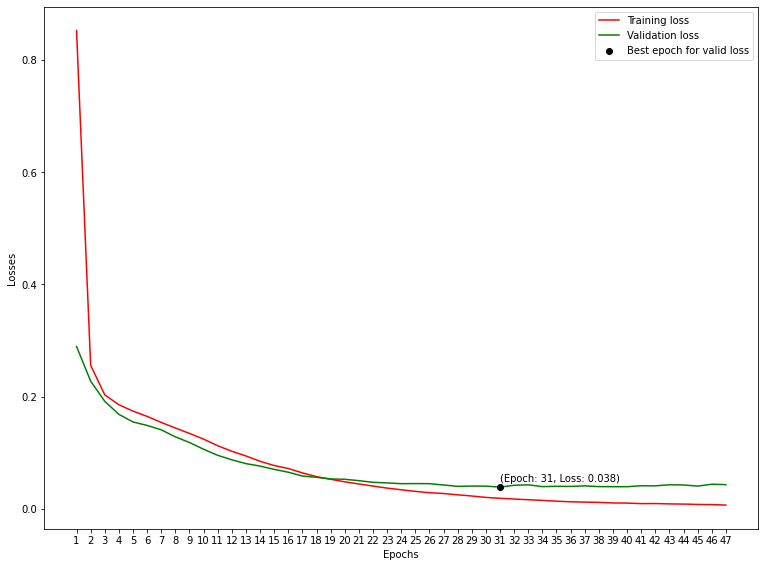

In [ ]:
ep = np.arange(1,epoch+2,1)

print()
print("The lowest loss is at the epoch", np.argmin(valid_losses)+1)

# PLOTS
plt.figure(figsize=(6.4*2, 4.8*2), constrained_layout=False)
# Validation and training curve
plt.plot(ep, train_losses, c = "red", label = "Training loss")
plt.plot(ep, valid_losses, c = "green", label = "Validation loss")
# Best epoch fot validation loss
plt.scatter(np.argmin(valid_losses)+1, valid_losses[np.argmin(valid_losses)], 
            c = "black", label = "Best epoch for valid loss", zorder=3)
plt.text(np.argmin(valid_losses)+1 + 0.01, valid_losses[np.argmin(valid_losses)] + 0.01, 
         '(Epoch: {}, Loss: {})'.format(np.argmin(valid_losses)+1, 
                                        np.round(valid_losses[np.argmin(valid_losses)], 3)), 
         zorder=4)
# Esthetics
plt.xticks(ep)
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.legend()

##Spanish

###Dataset/Dataloader initialization

In [ ]:
print("Reading Train Set...")
train_dataset = MyDataset("train", "es")
train_data_loader = data_loading(train_dataset, True)

print("\nReading Dev Set...")
dev_dataset = MyDataset("dev", "es")
dev_data_loader = data_loading(dev_dataset, False)

Reading Train Set...


Encode:   0%|          | 0/464 [00:00<?, ?it/s]

set type: trainSet
language: es
tokenizer used: bert-base-uncased
set length: 1075
batch size: 32
number of batches: 34

Reading Dev Set...


Encode:   0%|          | 0/1026 [00:00<?, ?it/s]

set type: devSet
language: es
tokenizer used: bert-base-uncased
set length: 2495
batch size: 32
number of batches: 78


### Model initialization

In [ ]:
model_es = SRL_Model_2(hparams).to(DEVICE)
# Fine funing from the best english checkpoint
model_es.load_state_dict(torch.load(CHECKPOINTS_PATH + "EN/name__base_model_en_last_val___transformer_name__bert-base-uncased___hidden_dim_LSTM__200___embedding_dim__200.pt", map_location=torch.device(DEVICE)))

groups = [
  {
    "params": model_es.classifier.parameters(),
    "lr": LEARNING_RATE,
    "weight_decay": WEIGHT_DECAY,
  },
  {
    "params": model_es.transformer_model.parameters(),
    "lr": TRANSFORMER_LEARNING_RATE,
    "weight_decay": TRANSFORMER_WEIGHT_DECAY,
  },
]
optimizer = torch.optim.Adam(groups)

chk_name = str(save_hparams).replace("\n", " ").replace("{", "").replace("}", "").replace("'", "").replace(":", "").replace(",", "_").replace(" ", "__")
chk_name += ".pt"
trainer = Trainer(model_es, optimizer, chk_name)
print(chk_name)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


transformer_name__bert-base-uncased___hidden_dim_LSTM__200___embedding_dim__200.pt


### Training and validation

In [ ]:
train_losses, valid_losses, epoch = trainer.train(train_data_loader, dev_data_loader, train_dataset.language, EPOCHS)

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Training - Batch:   0%|          | 0/34 [00:00<?, ?it/s]

Validation - Batch:   0%|          | 0/78 [00:00<?, ?it/s]

Training - Batch:   0%|          | 0/34 [00:00<?, ?it/s]

Validation - Batch:   0%|          | 0/78 [00:00<?, ?it/s]

Training - Batch:   0%|          | 0/34 [00:00<?, ?it/s]

Validation - Batch:   0%|          | 0/78 [00:00<?, ?it/s]

Training - Batch:   0%|          | 0/34 [00:00<?, ?it/s]

Validation - Batch:   0%|          | 0/78 [00:00<?, ?it/s]

Training - Batch:   0%|          | 0/34 [00:00<?, ?it/s]

Validation - Batch:   0%|          | 0/78 [00:00<?, ?it/s]

Training - Batch:   0%|          | 0/34 [00:00<?, ?it/s]

Validation - Batch:   0%|          | 0/78 [00:00<?, ?it/s]

Training - Batch:   0%|          | 0/34 [00:00<?, ?it/s]

Validation - Batch:   0%|          | 0/78 [00:00<?, ?it/s]

Training - Batch:   0%|          | 0/34 [00:00<?, ?it/s]

Validation - Batch:   0%|          | 0/78 [00:00<?, ?it/s]

Training - Batch:   0%|          | 0/34 [00:00<?, ?it/s]

Validation - Batch:   0%|          | 0/78 [00:00<?, ?it/s]

Training - Batch:   0%|          | 0/34 [00:00<?, ?it/s]

Validation - Batch:   0%|          | 0/78 [00:00<?, ?it/s]

Training - Batch:   0%|          | 0/34 [00:00<?, ?it/s]

Validation - Batch:   0%|          | 0/78 [00:00<?, ?it/s]

Training - Batch:   0%|          | 0/34 [00:00<?, ?it/s]

Validation - Batch:   0%|          | 0/78 [00:00<?, ?it/s]


Early stopping!!


### Result
A plot of the losses


The lowest loss is at the epoch 4


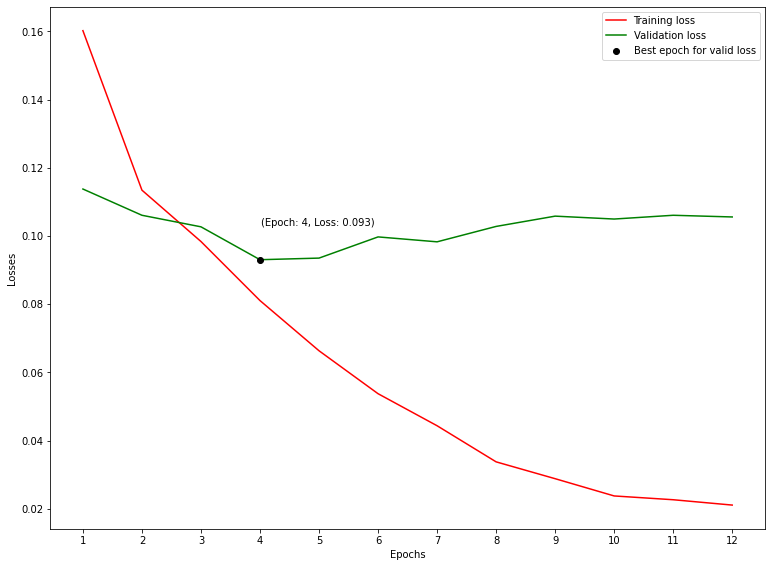

In [ ]:
ep = np.arange(1,epoch+2,1)

print()
print("The lowest loss is at the epoch", np.argmin(valid_losses)+1)

# PLOTS
plt.figure(figsize=(6.4*2, 4.8*2), constrained_layout=False)
# Validation and training curve
plt.plot(ep, train_losses, c = "red", label = "Training loss")
plt.plot(ep, valid_losses, c = "green", label = "Validation loss")
# Best epoch fot validation loss
plt.scatter(np.argmin(valid_losses)+1, valid_losses[np.argmin(valid_losses)], 
            c = "black", label = "Best epoch for valid loss", zorder=3)
plt.text(np.argmin(valid_losses)+1 + 0.01, valid_losses[np.argmin(valid_losses)] + 0.01, 
         '(Epoch: {}, Loss: {})'.format(np.argmin(valid_losses)+1, 
                                        np.round(valid_losses[np.argmin(valid_losses)], 3)), 
         zorder=4)
# Esthetics
plt.xticks(ep)
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.legend()

## French

###Dataset/Dataloader initialization

In [ ]:
print("Reading Train Set...")
train_dataset = MyDataset("train", "fr")
train_data_loader = data_loading(train_dataset, True)

print("\nReading Dev Set...")
dev_dataset = MyDataset("dev", "fr")
dev_data_loader = data_loading(dev_dataset, False)

Reading Train Set...


Encode:   0%|          | 0/464 [00:00<?, ?it/s]

set type: trainSet
language: fr
tokenizer used: bert-base-uncased
set length: 1121
batch size: 32
number of batches: 36

Reading Dev Set...


Encode:   0%|          | 0/1026 [00:00<?, ?it/s]

set type: devSet
language: fr
tokenizer used: bert-base-uncased
set length: 2555
batch size: 32
number of batches: 80


### Model initialization

In [ ]:
model_es = SRL_Model_2(hparams).to(DEVICE)
# Fine funing from the best english checkpoint
model_es.load_state_dict(torch.load(CHECKPOINTS_PATH + "EN/name__base_model_en_last_val___transformer_name__bert-base-uncased___hidden_dim_LSTM__200___embedding_dim__200.pt", map_location=torch.device(DEVICE)))

groups = [
  {
    "params": model_es.classifier.parameters(),
    "lr": LEARNING_RATE,
    "weight_decay": WEIGHT_DECAY,
  },
  {
    "params": model_es.transformer_model.parameters(),
    "lr": TRANSFORMER_LEARNING_RATE,
    "weight_decay": TRANSFORMER_WEIGHT_DECAY,
  },
]
optimizer = torch.optim.Adam(groups)

chk_name = str(save_hparams).replace("\n", " ").replace("{", "").replace("}", "").replace("'", "").replace(":", "").replace(",", "_").replace(" ", "__")
chk_name += ".pt"
trainer = Trainer(model_es, optimizer, chk_name)
print(chk_name)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


transformer_name__bert-base-uncased___hidden_dim_LSTM__200___embedding_dim__200.pt


### Training and validation

In [ ]:
train_losses, valid_losses, epoch = trainer.train(train_data_loader, dev_data_loader, train_dataset.language, EPOCHS)

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Training - Batch:   0%|          | 0/36 [00:00<?, ?it/s]

Validation - Batch:   0%|          | 0/80 [00:00<?, ?it/s]

Training - Batch:   0%|          | 0/36 [00:00<?, ?it/s]

Validation - Batch:   0%|          | 0/80 [00:00<?, ?it/s]

Training - Batch:   0%|          | 0/36 [00:00<?, ?it/s]

Validation - Batch:   0%|          | 0/80 [00:00<?, ?it/s]

Training - Batch:   0%|          | 0/36 [00:00<?, ?it/s]

Validation - Batch:   0%|          | 0/80 [00:00<?, ?it/s]

Training - Batch:   0%|          | 0/36 [00:00<?, ?it/s]

Validation - Batch:   0%|          | 0/80 [00:00<?, ?it/s]

Training - Batch:   0%|          | 0/36 [00:00<?, ?it/s]

Validation - Batch:   0%|          | 0/80 [00:00<?, ?it/s]

Training - Batch:   0%|          | 0/36 [00:00<?, ?it/s]

Validation - Batch:   0%|          | 0/80 [00:00<?, ?it/s]

Training - Batch:   0%|          | 0/36 [00:00<?, ?it/s]

Validation - Batch:   0%|          | 0/80 [00:00<?, ?it/s]

Training - Batch:   0%|          | 0/36 [00:00<?, ?it/s]

Validation - Batch:   0%|          | 0/80 [00:00<?, ?it/s]

Training - Batch:   0%|          | 0/36 [00:00<?, ?it/s]

Validation - Batch:   0%|          | 0/80 [00:00<?, ?it/s]

Training - Batch:   0%|          | 0/36 [00:00<?, ?it/s]

Validation - Batch:   0%|          | 0/80 [00:00<?, ?it/s]

Training - Batch:   0%|          | 0/36 [00:00<?, ?it/s]

Validation - Batch:   0%|          | 0/80 [00:00<?, ?it/s]


Early stopping!!


### Result
A plot of the losses


The lowest loss is at the epoch 5


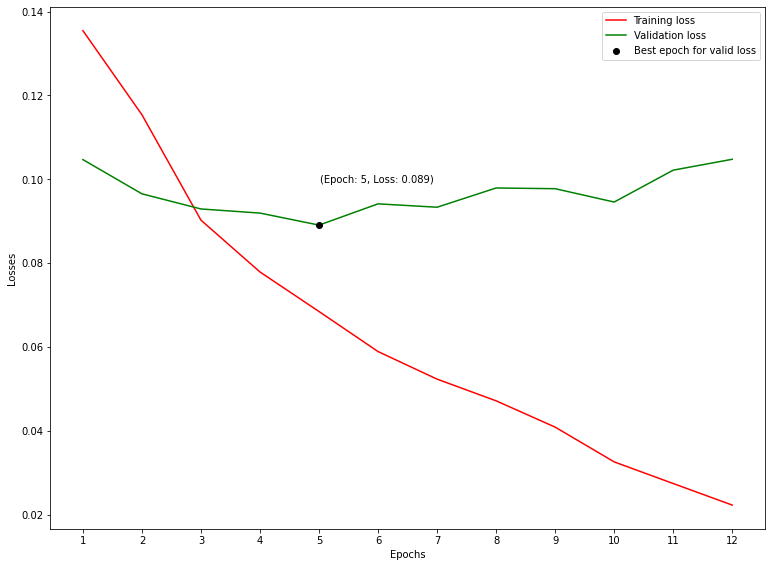

In [ ]:
ep = np.arange(1,epoch+2,1)

print()
print("The lowest loss is at the epoch", np.argmin(valid_losses)+1)

# PLOTS
plt.figure(figsize=(6.4*2, 4.8*2), constrained_layout=False)
# Validation and training curve
plt.plot(ep, train_losses, c = "red", label = "Training loss")
plt.plot(ep, valid_losses, c = "green", label = "Validation loss")
# Best epoch fot validation loss
plt.scatter(np.argmin(valid_losses)+1, valid_losses[np.argmin(valid_losses)], 
            c = "black", label = "Best epoch for valid loss", zorder=3)
plt.text(np.argmin(valid_losses)+1 + 0.01, valid_losses[np.argmin(valid_losses)] + 0.01, 
         '(Epoch: {}, Loss: {})'.format(np.argmin(valid_losses)+1, 
                                        np.round(valid_losses[np.argmin(valid_losses)], 3)), 
         zorder=4)
# Esthetics
plt.xticks(ep)
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.legend()